# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [130]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

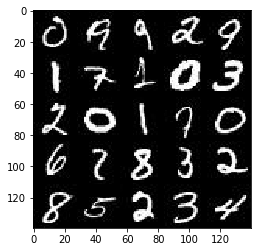

In [131]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

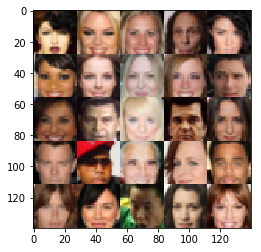

In [132]:
show_n_images = 25


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [133]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [134]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    return tf.placeholder(tf.float32, name='input_real', shape=[None, image_width, image_height, image_channels]), \
        tf.placeholder(tf.float32, name='input_z', shape=[None, z_dim]), \
        tf.placeholder(tf.float32, name='learning_rate', shape=[])



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [135]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # input 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='valid')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # flatten
        flat = tf.reshape(relu3, (-1, 6*6*128))
        #flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [136]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    alpha = 0.2
    #print("Channel dim = ", out_channel_dim)
    chan = 4
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        
        # First connected layer
        x1 = tf.layers.dense(z, 7*7*chan*100)
        
        # Reshape it to start the conv stack
        x1 = tf.reshape(x1, (-1, 7, 7, chan*100))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # now 7 x 7 x 100 x chan
        
        x2 = tf.layers.conv2d_transpose(x1, chan*50, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # now 14 x 14 x 50 x chan
        
        x3 = tf.layers.conv2d_transpose(x2, chan*25, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # now 28 x 28 x 25 x chan
        
        x4 = tf.layers.conv2d_transpose(x3, chan*8, 3, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # now 56 x 56 x 8 x chan
        
        # Output layer
        logits = tf.layers.conv2d(x4, out_channel_dim, 5, strides=1, padding='same')

        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [137]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_output = generator(input_z, out_channel_dim, is_train=True)
    d_real_output, d_real_logits = discriminator(input_real)    
    d_fake_output, d_fake_logits = discriminator(g_output, reuse=True)
        
    d_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, 
                                                labels=tf.ones_like(d_real_output) * (1 - smooth)
        ))
    d_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,
                                                labels=tf.zeros_like(d_fake_output)
        ))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, 
                                                labels=tf.ones_like(d_fake_output)
        ))
    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [138]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [139]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [140]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    steps = 0
    _, width, height, chans = data_shape
        
    input_real, input_z, var_learning_rate = model_inputs(width, height, chans, z_dim)
    d_loss_t, g_loss_t = model_loss(input_real, input_z, chans)
    d_opt, g_opt = model_opt(d_loss_t, g_loss_t, learning_rate, beta1)
    
    #saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                feed ={
                    input_real: batch_images,
                    input_z: batch_z,
                    var_learning_rate: learning_rate
                   }               
                _, _ = sess.run([g_loss_t, g_opt], feed_dict=feed)
                g_loss, _ = sess.run([g_loss_t, g_opt], feed_dict=feed)
                d_loss, _ = sess.run([d_loss_t, d_opt], feed_dict=feed)
                
                if steps % 20 == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss),
                          "Generator Loss: {:.4f}".format(g_loss))

                if steps % 100 == 0:
                    show_generator_output(sess, 36, input_z, chans, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9657... Generator Loss: 2.1982
Epoch 1/2... Discriminator Loss: 3.1114... Generator Loss: 0.6224
Epoch 1/2... Discriminator Loss: 1.1163... Generator Loss: 1.5077
Epoch 1/2... Discriminator Loss: 0.7204... Generator Loss: 2.2513
Epoch 1/2... Discriminator Loss: 2.0189... Generator Loss: 0.9779


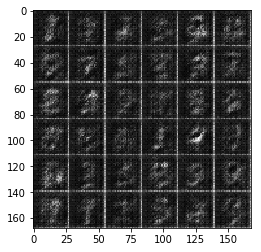

Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 1.0347
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 1.1841
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 1.2108
Epoch 1/2... Discriminator Loss: 1.2033... Generator Loss: 1.3291
Epoch 1/2... Discriminator Loss: 1.1861... Generator Loss: 1.6020


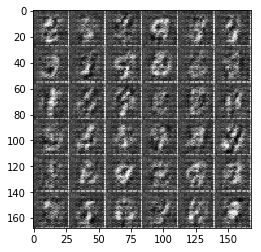

Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 1.1701
Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 1.1797
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 1.0305
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 1.4623
Epoch 1/2... Discriminator Loss: 1.0994... Generator Loss: 1.2091


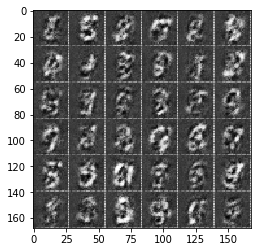

Epoch 1/2... Discriminator Loss: 1.0355... Generator Loss: 1.4309
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 1.8736
Epoch 1/2... Discriminator Loss: 1.0245... Generator Loss: 1.6235
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 1.2499
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 1.8724


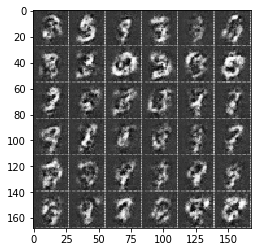

Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 1.4949
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 1.2705
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 1.1878
Epoch 1/2... Discriminator Loss: 0.9577... Generator Loss: 1.6323
Epoch 1/2... Discriminator Loss: 1.1826... Generator Loss: 2.0400


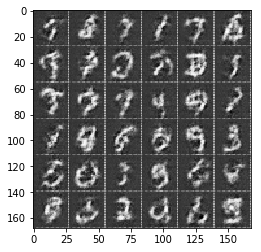

Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 0.8839
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 1.1396
Epoch 1/2... Discriminator Loss: 1.0768... Generator Loss: 1.1993
Epoch 1/2... Discriminator Loss: 1.2307... Generator Loss: 0.9833


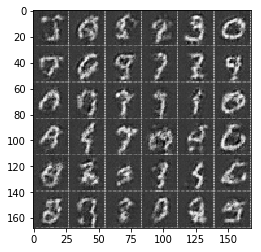

Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 1.3426
Epoch 1/2... Discriminator Loss: 1.0682... Generator Loss: 1.1993
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 0.8330
Epoch 1/2... Discriminator Loss: 1.1002... Generator Loss: 1.8000
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 1.1853


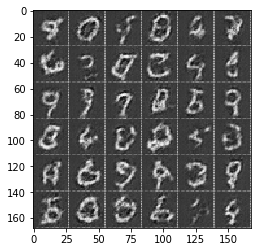

Epoch 1/2... Discriminator Loss: 0.9854... Generator Loss: 1.7683
Epoch 1/2... Discriminator Loss: 1.0976... Generator Loss: 1.6481
Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 1.3195
Epoch 1/2... Discriminator Loss: 0.9494... Generator Loss: 1.9038
Epoch 1/2... Discriminator Loss: 1.0151... Generator Loss: 1.4480


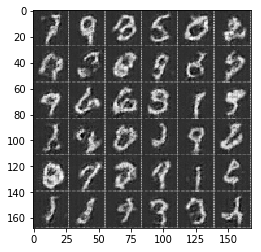

Epoch 1/2... Discriminator Loss: 1.0115... Generator Loss: 1.3433
Epoch 1/2... Discriminator Loss: 0.9933... Generator Loss: 2.0265
Epoch 1/2... Discriminator Loss: 1.0910... Generator Loss: 2.4432
Epoch 1/2... Discriminator Loss: 0.9683... Generator Loss: 2.1169
Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 1.5432


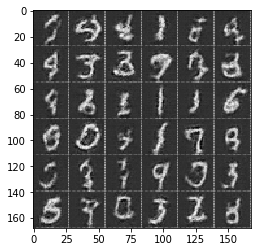

Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 1.2418
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.6841
Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 1.6242
Epoch 2/2... Discriminator Loss: 0.9533... Generator Loss: 1.5805
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 2.4515


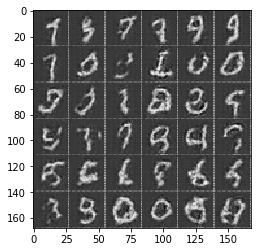

Epoch 2/2... Discriminator Loss: 0.7422... Generator Loss: 2.0862
Epoch 2/2... Discriminator Loss: 0.9090... Generator Loss: 1.8647
Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 1.5579
Epoch 2/2... Discriminator Loss: 0.8639... Generator Loss: 1.7471
Epoch 2/2... Discriminator Loss: 0.9390... Generator Loss: 1.7374


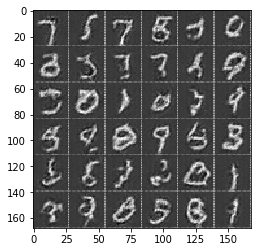

Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 2.0504
Epoch 2/2... Discriminator Loss: 0.9731... Generator Loss: 1.3854
Epoch 2/2... Discriminator Loss: 1.0316... Generator Loss: 2.3434
Epoch 2/2... Discriminator Loss: 0.9140... Generator Loss: 1.6873
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 2.6442


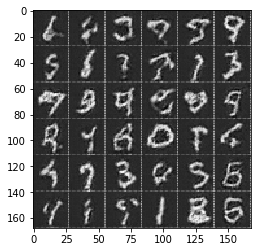

Epoch 2/2... Discriminator Loss: 0.7732... Generator Loss: 2.0361
Epoch 2/2... Discriminator Loss: 0.9339... Generator Loss: 2.1751
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 1.9024
Epoch 2/2... Discriminator Loss: 0.7497... Generator Loss: 1.9527
Epoch 2/2... Discriminator Loss: 0.9877... Generator Loss: 1.3655


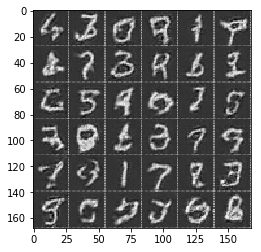

Epoch 2/2... Discriminator Loss: 1.0781... Generator Loss: 2.3762
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 1.6316
Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 1.0578
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 2.4457
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.5538


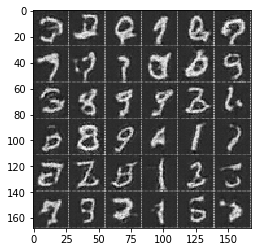

Epoch 2/2... Discriminator Loss: 1.0041... Generator Loss: 1.2061
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 1.3480
Epoch 2/2... Discriminator Loss: 0.8518... Generator Loss: 1.3642
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 1.2982
Epoch 2/2... Discriminator Loss: 0.9903... Generator Loss: 1.7474


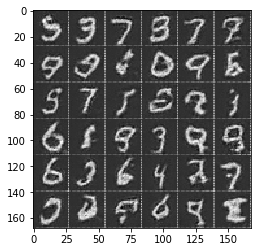

Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 1.8351
Epoch 2/2... Discriminator Loss: 1.0475... Generator Loss: 1.1096
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 1.6647
Epoch 2/2... Discriminator Loss: 0.7817... Generator Loss: 1.6144
Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 2.6351


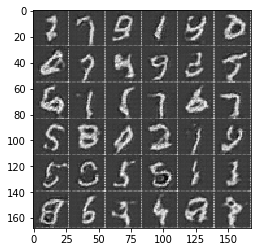

Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 0.9917
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 2.2043
Epoch 2/2... Discriminator Loss: 0.7848... Generator Loss: 1.8163
Epoch 2/2... Discriminator Loss: 0.8652... Generator Loss: 1.4391
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 1.6828


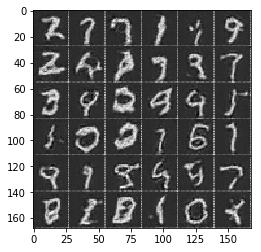

Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 2.0928
Epoch 2/2... Discriminator Loss: 1.1157... Generator Loss: 1.1589
Epoch 2/2... Discriminator Loss: 0.8162... Generator Loss: 1.9432
Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 1.0870
Epoch 2/2... Discriminator Loss: 0.8696... Generator Loss: 1.6460


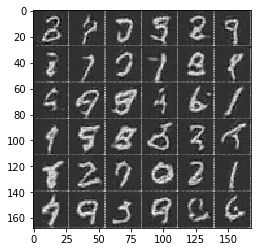

Epoch 2/2... Discriminator Loss: 1.0363... Generator Loss: 2.7135
Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 2.4578
Epoch 2/2... Discriminator Loss: 0.9356... Generator Loss: 1.5424


In [ ]:
batch_size = 64
z_dim = 200
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4021... Generator Loss: 1.2667
Epoch 1/1... Discriminator Loss: 1.7491... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 1.6645
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.9684... Generator Loss: 1.3435


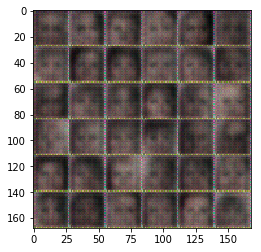

Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 2.0798
Epoch 1/1... Discriminator Loss: 1.7080... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.9037


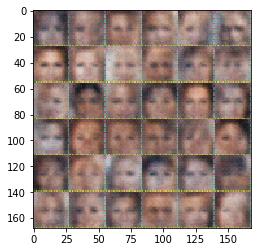

Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.8163


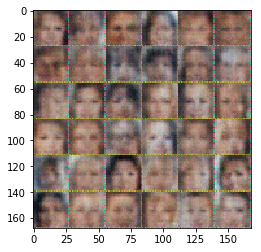

Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.8189


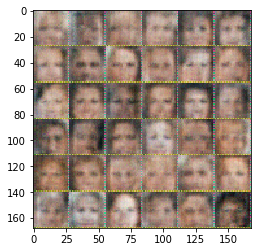

Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7777


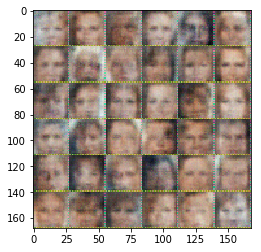

Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8260


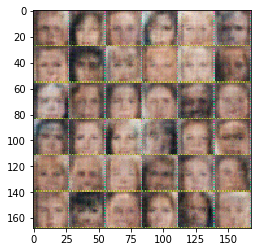

Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.8268


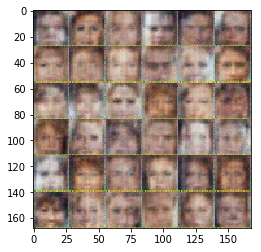

Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7690


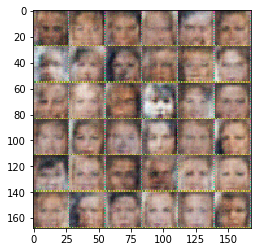

Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7907


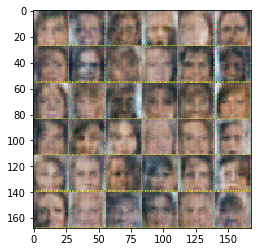

Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7790


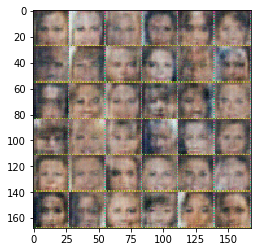

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7524


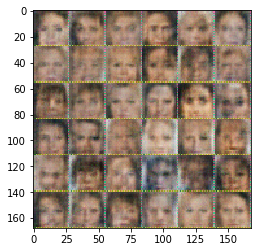

Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.8077


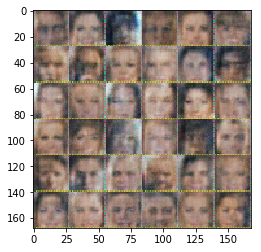

Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7837


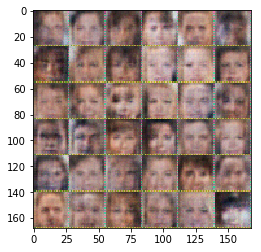

Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.8429


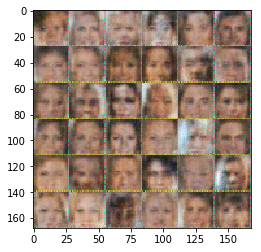

Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8225


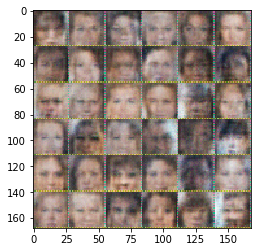

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8032


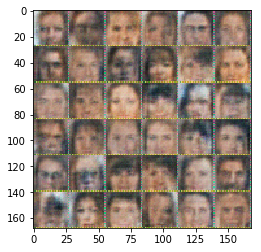

Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8127


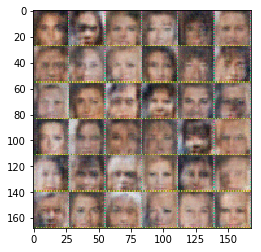

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7749


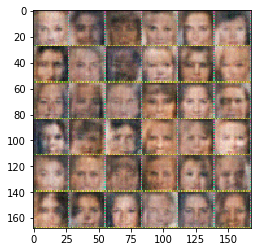

Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7390


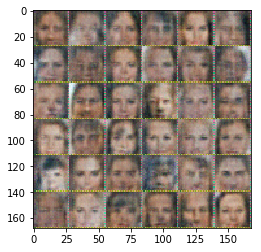

Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7757


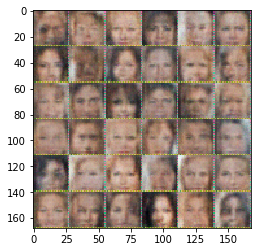

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.8369


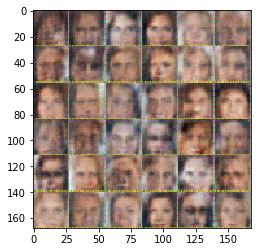

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7765


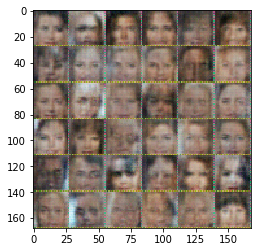

Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7614


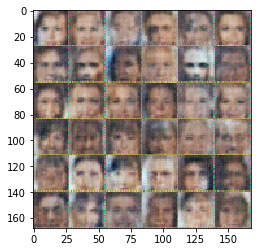

Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7808


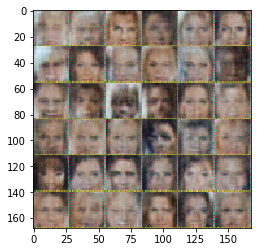

Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8092


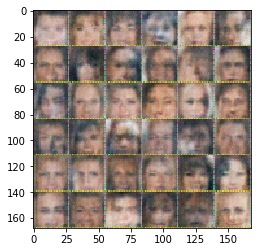

Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7758


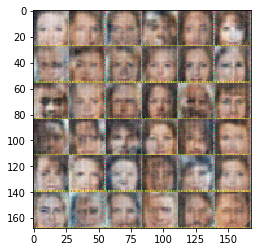

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7772


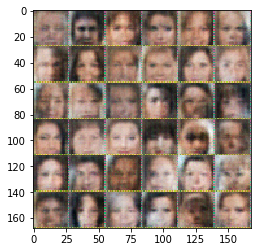

Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.8096


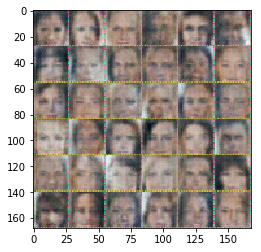

Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7530


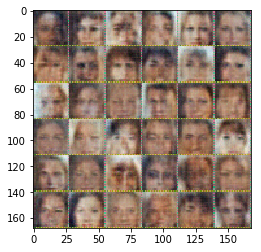

Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7699


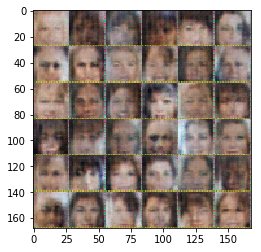

Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.9158


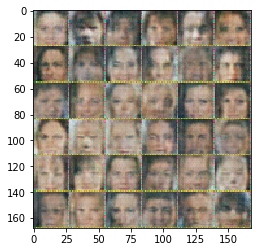

Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7774


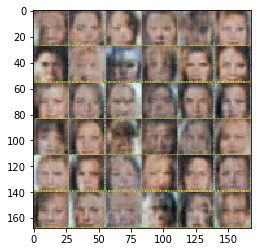

Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.8109


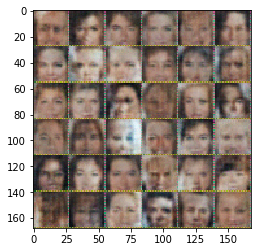

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7891


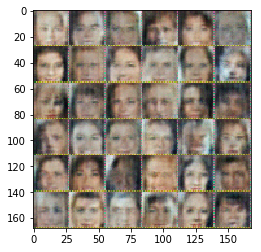

Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8523


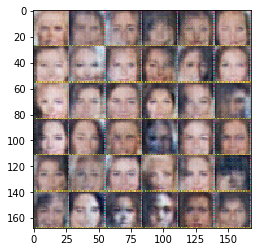

Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7586


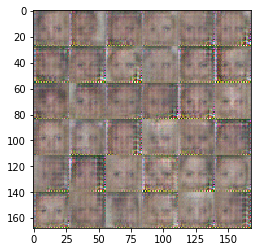

Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.8049


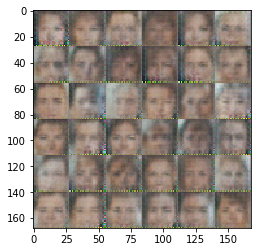

Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.8231


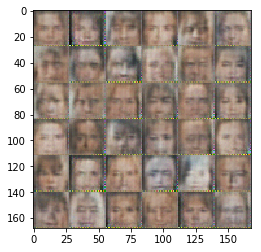

Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7991


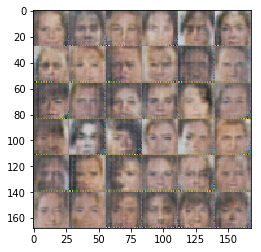

Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7907


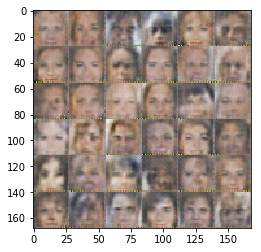

Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7827


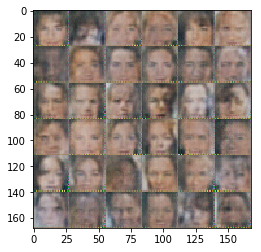

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8122


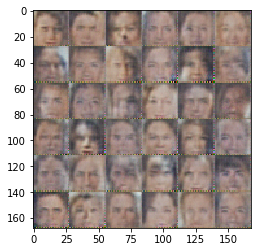

Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8078


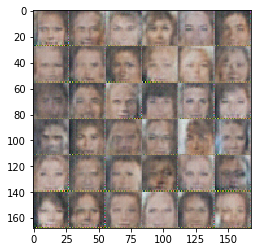

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8084


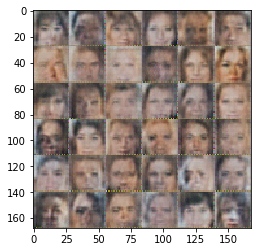

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7972


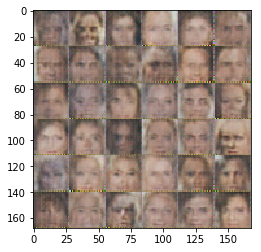

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.8632


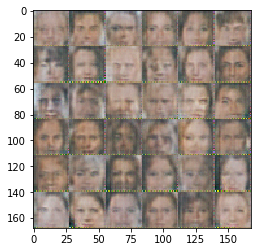

Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7432


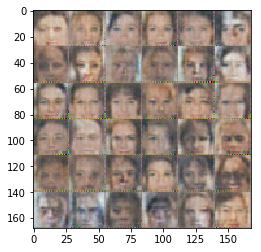

Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7620


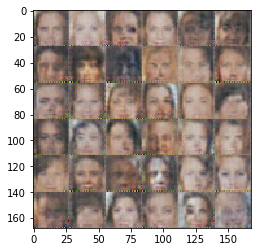

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7395


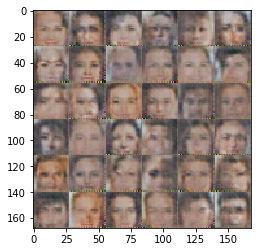

Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7675


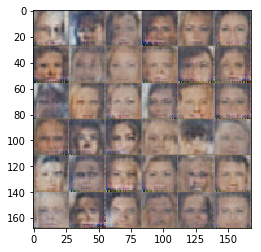

Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7916


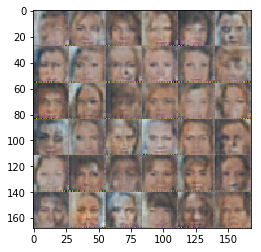

Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.8130


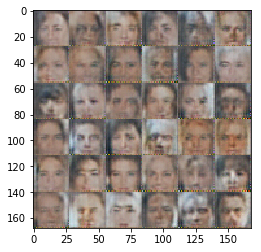

Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7997


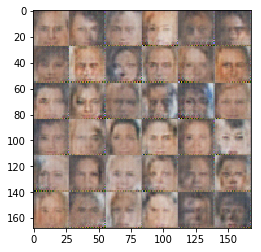

Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8050


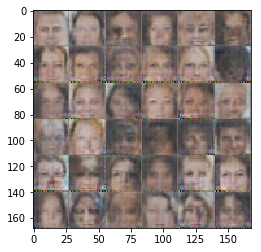

Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8070


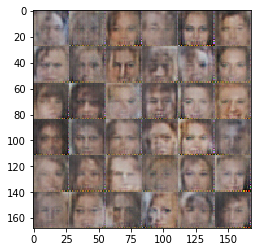

Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8062


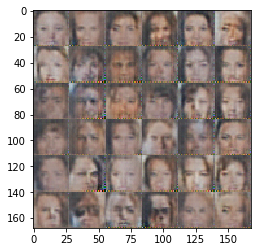

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7806


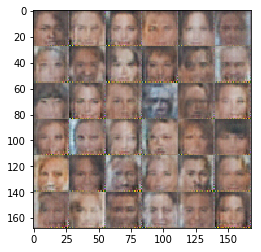

Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7771


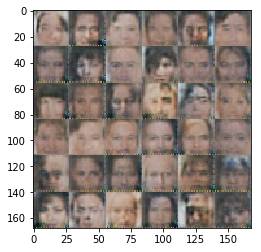

Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8391


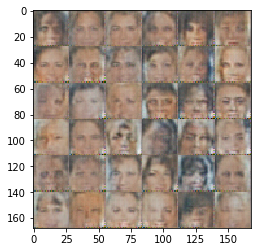

Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7986


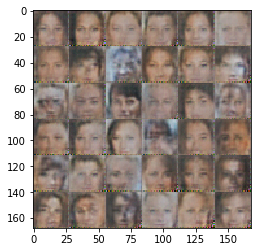

Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.8049


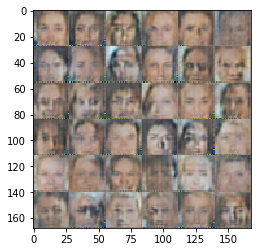

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.8016


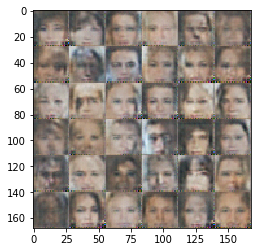

Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8171


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.